In [ ]:
!pip install pyvi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import json
import math
import numpy as np
from collections import Counter
from pyvi import ViTokenizer

# Kiểm tra thiết bị (GPU hay CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Đang sử dụng thiết bị: {device}")

Đang sử dụng thiết bị: cuda


Train: Đã đọc 4387 câu.
Dev: Đã đọc 548 câu.
Test: Đã đọc 549 câu.

KẾT QUẢ PHÂN TÍCH ĐỘ DÀI (Toàn bộ dataset)
Min length: 1
Max length: 251
Mean length: 27.81
Median length: 18.0
--------------------
Top 90% câu ngắn hơn: 68 tokens
Top 95% câu ngắn hơn: 73 tokens
Top 99% câu ngắn hơn: 82 tokens


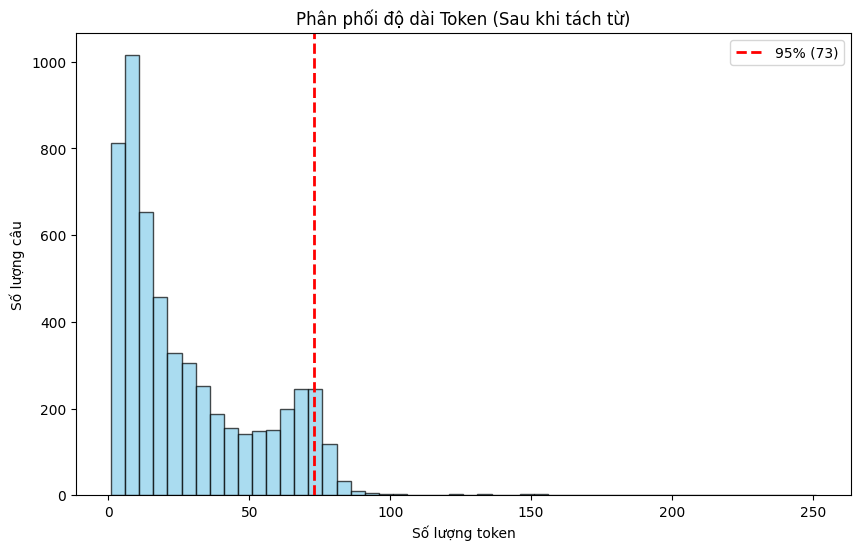

In [ ]:
import matplotlib.pyplot as plt

# Danh sách các file cần soi
files = {
    'Train': '/content/drive/MyDrive/UIT-ViOCD/train.json',
    'Dev':   '/content/drive/MyDrive/UIT-ViOCD/dev.json',
    'Test':  '/content/drive/MyDrive/UIT-ViOCD/test.json'
}

all_lengths = []

for name, path in files.items():
    lengths = []
    try:
        with open(path, 'r', encoding='utf-8') as f:
            raw_data = json.load(f)
            # Xử lý cấu trúc dict {"0": ...}
            items = raw_data.values()

            for item in items:
                text = item.get('review', '')
                if text:
                    # Tokenize y hệt như lúc train
                    tokenized = ViTokenizer.tokenize(text)
                    # Đếm số từ
                    n_tokens = len(tokenized.split())
                    lengths.append(n_tokens)

        print(f"{name}: Đã đọc {len(lengths)} câu.")
        all_lengths.extend(lengths)

    except FileNotFoundError:
        print(f"{name}: Không tìm thấy file tại {path}")

# --- Thống kê ---
all_lengths = np.array(all_lengths)

if len(all_lengths) > 0:
    print("\n" + "="*40)
    print("KẾT QUẢ PHÂN TÍCH ĐỘ DÀI (Toàn bộ dataset)")
    print("="*40)
    print(f"Min length: {np.min(all_lengths)}")
    print(f"Max length: {np.max(all_lengths)}")
    print(f"Mean length: {np.mean(all_lengths):.2f}")
    print(f"Median length: {np.median(all_lengths)}")

    #  Các mốc phần trăm (Percentiles)
    p90 = np.percentile(all_lengths, 90)
    p95 = np.percentile(all_lengths, 95)
    p99 = np.percentile(all_lengths, 99)

    print("-" * 20)
    print(f"Top 90% câu ngắn hơn: {int(p90)} tokens")
    print(f"Top 95% câu ngắn hơn: {int(p95)} tokens")
    print(f"Top 99% câu ngắn hơn: {int(p99)} tokens")
    print("="*40)

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 6))
    plt.hist(all_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(p95, color='red', linestyle='dashed', linewidth=2, label=f'95% ({int(p95)})')
    plt.title('Phân phối độ dài Token (Sau khi tách từ)')
    plt.xlabel('Số lượng token')
    plt.ylabel('Số lượng câu')
    plt.legend()
    plt.show()
else:
    print("Không có dữ liệu để phân tích.")

=> Chọn max_len là 100

In [ ]:
# CELL 2: Configuration (Updated)
config = {
    # --- Data Paths ---
    'train_path': '/content/drive/MyDrive/UIT-ViOCD/train.json',
    'val_path':   '/content/drive/MyDrive/UIT-ViOCD/dev.json',  # Tập validation
    'test_path':  '/content/drive/MyDrive/UIT-ViOCD/test.json', # Tập test

    # --- Paper Hyperparameters [Attention Is All You Need] ---
    'd_model': 512,
    'n_head': 8,
    'n_layers': 3,       # Yêu cầu đề bài (Gốc là 6)
    'd_ff': 2048,
    'dropout': 0.1,
    'label_smoothing': 0.1,

    # --- Training Config ---
    'max_len': 100,
    'batch_size': 32,
    'warmup_steps': 2000,
    'epochs': 100
}

In [ ]:
class ViOCDDataset(Dataset):
    def __init__(self, json_path, vocab=None, max_len=None, is_train=True):
        # max_len ở đây chỉ dùng để CẮT bớt nếu câu quá dài (hard limit), không dùng để pad
        self.data = []
        labels = set()
        self.hard_limit = max_len if max_len else 512 # Giới hạn cứng để tránh lỗi bộ nhớ

        print(f"Đang đọc file: {json_path}")
        with open(json_path, 'r', encoding='utf-8') as f:
            raw_data = json.load(f)
            for item in raw_data.values():
                text = item.get('review', '')
                label = item.get('domain', '')

                if text and label:
                    # Tách từ tiếng Việt
                    tokenized_text = ViTokenizer.tokenize(text)
                    self.data.append((tokenized_text, label))
                    labels.add(label)

        self.label_map = {l: i for i, l in enumerate(sorted(list(labels)))}
        self.num_classes = len(labels)

        if is_train:
            all_tokens = [w for text, _ in self.data for w in text.lower().split()]
            word_counts = Counter(all_tokens)
            # PAD phải có ID = 0 để hàm pad_sequence mặc định hiểu
            tokens = ['<PAD>', '<UNK>'] + [w for w, c in word_counts.items() if c >= 2]
            self.vocab = {w: i for i, w in enumerate(tokens)}
        else:
            self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, label_str = self.data[idx]
        tokens = text.lower().split()

        # Chuyển từ -> index
        idx_seq = [self.vocab.get(w, self.vocab['<UNK>']) for w in tokens]

        # CHỈ CẮT (Truncate) nếu dài hơn giới hạn cứng, KHÔNG PAD
        if len(idx_seq) > self.hard_limit:
            idx_seq = idx_seq[:self.hard_limit]

        return torch.tensor(idx_seq, dtype=torch.long), torch.tensor(self.label_map[label_str], dtype=torch.long)

In [ ]:
from torch.nn.utils.rnn import pad_sequence

# Hàm này sẽ được gọi khi DataLoader gom các mẫu lại thành 1 batch
def collate_batch(batch):
    # batch là list các tuple: [(seq1, label1), (seq2, label2), ...]

    label_list, text_list = [], []

    for (_text, _label) in batch:
        label_list.append(_label)
        text_list.append(_text)

    # Chuyển label thành tensor
    label_list = torch.tensor(label_list, dtype=torch.long)

    # PAD ĐỘNG: PyTorch tự tìm câu dài nhất trong list này và pad các câu còn lại theo nó
    # padding_value=0 vì ID của <PAD> trong vocab là 0
    text_pad = pad_sequence(text_list, batch_first=True, padding_value=0)

    return text_pad, label_list

# --- Khởi tạo ---

# 1. Train
print("--- Load TRAIN ---")
train_dataset = ViOCDDataset(config['train_path'], is_train=True, max_len=config['max_len'])
# Chú ý tham số collate_fn
train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=collate_batch
)

vocab_traintiep = train_dataset.vocab

# 2. Dev
print("--- Load DEV ---")
val_dataset = ViOCDDataset(config['val_path'], vocab=vocab_traintiep, is_train=False, max_len=config['max_len'])
val_loader = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    collate_fn=collate_batch
)

# 3. Test
print("--- Load TEST ---")
test_dataset = ViOCDDataset(config['test_path'], vocab=vocab_traintiep, is_train=False, max_len=config['max_len'])
test_loader = DataLoader(
    test_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    collate_fn=collate_batch
)

print("\nĐã thiết lập Dynamic Padding thành công!")
# Test thử batch đầu tiên xem kích thước thế nào
sample_batch_text, sample_batch_label = next(iter(train_loader))
print(f"Kích thước batch ngẫu nhiên: {sample_batch_text.shape}")

--- Load TRAIN ---
Đang đọc file: /content/drive/MyDrive/UIT-ViOCD/train.json
--- Load DEV ---
Đang đọc file: /content/drive/MyDrive/UIT-ViOCD/dev.json
--- Load TEST ---
Đang đọc file: /content/drive/MyDrive/UIT-ViOCD/test.json

Đã thiết lập Dynamic Padding thành công!
Kích thước batch ngẫu nhiên: torch.Size([32, 78])


In [ ]:
len(train_dataset)

4387

In [ ]:
class PositionalEncoding(nn.Module):
    "Triển khai công thức PE(pos, 2i) = sin(...) và PE(pos, 2i+1) = cos(...)"
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x: [batch_size, seq_len, d_model]
        x = x + self.pe[:, :x.size(1), :]
        return x

class MultiHeadAttention(nn.Module):
    "Multi-Head Attention như mô tả ở phần 3.2.2"
    def __init__(self, d_model, n_head):
        super(MultiHeadAttention, self).__init__()
        assert d_model % n_head == 0

        self.d_k = d_model // n_head
        self.n_head = n_head
        self.d_model = d_model

        # Các ma trận trọng số Wq, Wk, Wv, Wo
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.fc = nn.Linear(d_model, d_model)

        self.scale = torch.sqrt(torch.FloatTensor([self.d_k]))

    def forward(self, q, k, v, mask=None):
        batch_size = q.shape[0]

        # 1. Linear Project & Tách Head
        Q = self.w_q(q).view(batch_size, -1, self.n_head, self.d_k).transpose(1, 2)
        K = self.w_k(k).view(batch_size, -1, self.n_head, self.d_k).transpose(1, 2)
        V = self.w_v(v).view(batch_size, -1, self.n_head, self.d_k).transpose(1, 2)

        # 2. Scaled Dot-Product Attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale.to(Q.device)

        if mask is not None:
            # Mask padding (những chỗ = 0 sẽ bị gán giá trị rất âm để softmax ra 0)
            mask = mask.unsqueeze(1).unsqueeze(2) # [batch, 1, 1, seq_len]
            scores = scores.masked_fill(mask == 0, -1e9)

        attn = torch.softmax(scores, dim=-1)
        context = torch.matmul(attn, V)

        # 3. Concat & Final Linear
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.fc(context)

class PositionwiseFeedForward(nn.Module):
    "Mạng FFN gồm 2 lớp Linear và ReLU ở giữa "
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.dropout(self.relu(self.fc1(x))))

class EncoderLayer(nn.Module):
    "Một lớp Encoder gồm: Self-Attention -> Add & Norm -> Feed Forward -> Add & Norm "
    def __init__(self, d_model, n_head, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, n_head)
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Sub-layer 1: Attention
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output)) # Residual Connection

        # Sub-layer 2: Feed Forward
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))  # Residual Connection
        return x

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes, config):
        super(TransformerClassifier, self).__init__()
        self.d_model = config['d_model']

        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, self.d_model, padding_idx=0)
        self.pos_encoding = PositionalEncoding(self.d_model)
        self.dropout = nn.Dropout(config['dropout'])

        # Stack N Encoder Layers (Đề bài yêu cầu N=3)
        self.layers = nn.ModuleList([
            EncoderLayer(self.d_model, config['n_head'], config['d_ff'], config['dropout'])
            for _ in range(config['n_layers'])
        ])

        # Classifier Head
        self.fc_out = nn.Linear(self.d_model, num_classes)

    def forward(self, x):
        # Tạo mask tự động: vị trí nào có token (>0) là True, padding (0) là False
        mask = (x != 0)

        # 1. Embed + Pos Encoding
        # Nhân với sqrt(d_model) theo bài báo
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        # 2. Qua các lớp Encoder
        for layer in self.layers:
            x = layer(x, mask)

        # 3. Pooling (Lấy trung bình các token để phân loại câu)
        # Chỉ lấy trung bình các vị trí không phải padding
        input_mask_expanded = mask.unsqueeze(-1).expand(x.size()).float()
        sum_embeddings = torch.sum(x * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9) # Tránh chia cho 0
        x = sum_embeddings / sum_mask

        return self.fc_out(x)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Sử dụng thiết bị: {device}")

# 1. Khởi tạo Model
model = TransformerClassifier(
    vocab_size=len(train_dataset.vocab),
    num_classes=train_dataset.num_classes,
    config=config
).to(device)

Sử dụng thiết bị: cuda


In [ ]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0, # LR sẽ được set bởi Scheduler bên dưới
    betas=(0.9, 0.98),
    eps=1e-9
)

In [ ]:
class LabelSmoothingLoss(nn.Module): # Class này giúp tránh làm cứng label trong quá trình training.
    "Triển khai Label Smoothing "
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

criterion = LabelSmoothingLoss(classes=train_dataset.num_classes, smoothing=config['label_smoothing'])
print("Mô hình đã được khởi tạo thành công.")

Mô hình đã được khởi tạo thành công.


In [ ]:
from sklearn.metrics import f1_score
import os


save_path = 'best_transformer_model.pth'

step_num = 0
best_val_f1 = 0.0 # Biến để theo dõi F1 tốt nhất

print(f"Bắt đầu huấn luyện {config['epochs']} epochs...")
print("-" * 80)

for epoch in range(config['epochs']):
    # ==========================
    # 1. TRAIN MODE
    # ==========================
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        step_num += 1

        # Cập nhật Learning Rate
        lr = (config['d_model'] ** -0.5) * min(step_num ** -0.5, step_num * (config['warmup_steps'] ** -1.5))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_acc = 100. * correct / total

    # ==========================
    # 2. VALIDATION MODE (Tính F1-Macro)
    # ==========================
    model.eval()
    val_preds = []
    val_targets = []
    val_loss = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Gom lại để tính F1
            pred = output.argmax(dim=1).cpu().numpy()
            target_np = target.cpu().numpy()

            val_preds.extend(pred)
            val_targets.extend(target_np)

    # Tính F1-Macro bằng Scikit-Learn
    val_f1 = f1_score(val_targets, val_preds, average='macro')
    val_acc = 100. * sum(p == t for p, t in zip(val_preds, val_targets)) / len(val_targets)

    print(f"Epoch {epoch+1:02d} | LR: {lr:.2e} | Train Loss: {avg_train_loss:.4f} | Val F1-Macro: {val_f1:.4f} (Acc: {val_acc:.2f}%)")

    # ==========================
    # 3. CHECKPOINTING (Lưu model tốt nhất)
    # ==========================
    if val_f1 > best_val_f1:
        print(f"Tìm thấy model tốt hơn! (F1 tăng từ {best_val_f1:.4f} lên {val_f1:.4f}). Đang lưu...")
        torch.save(model.state_dict(), save_path)
        best_val_f1 = val_f1

print("-" * 80)
print(f"Đã huấn luyện xong. F1-Macro tốt nhất trên Dev: {best_val_f1:.4f}")

# ==========================
# 4. TESTING (Load lại model tốt nhất để test)
# ==========================
print("\n Đang load lại checkpoint tốt nhất để đánh giá trên tập Test...")
model.load_state_dict(torch.load(save_path))
model.eval()

test_preds = []
test_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)

        pred = output.argmax(dim=1).cpu().numpy()
        target_np = target.cpu().numpy()

        test_preds.extend(pred)
        test_targets.extend(target_np)

# Tính kết quả cuối cùng
test_f1 = f1_score(test_targets, test_preds, average='macro')
test_acc = 100. * sum(p == t for p, t in zip(test_preds, test_targets)) / len(test_targets)

print("="*40)
print(f"KẾT QUẢ CUỐI CÙNG TRÊN TẬP TEST")
print(f"- Accuracy: {test_acc:.2f}%")
print(f"- F1-Macro: {test_f1:.4f}")
print("="*40)

Bắt đầu huấn luyện 100 epochs...
--------------------------------------------------------------------------------
Epoch 01 | LR: 6.82e-05 | Train Loss: 1.0972 | Val F1-Macro: 0.7246 (Acc: 81.02%)
Tìm thấy model tốt hơn! (F1 tăng từ 0.0000 lên 0.7246). Đang lưu...
Epoch 02 | LR: 1.36e-04 | Train Loss: 0.7883 | Val F1-Macro: 0.6989 (Acc: 78.10%)
Epoch 03 | LR: 2.05e-04 | Train Loss: 0.7088 | Val F1-Macro: 0.8326 (Acc: 87.59%)
Tìm thấy model tốt hơn! (F1 tăng từ 0.7246 lên 0.8326). Đang lưu...
Epoch 04 | LR: 2.73e-04 | Train Loss: 0.6508 | Val F1-Macro: 0.7766 (Acc: 84.31%)
Epoch 05 | LR: 3.41e-04 | Train Loss: 0.6298 | Val F1-Macro: 0.8327 (Acc: 87.96%)
Tìm thấy model tốt hơn! (F1 tăng từ 0.8326 lên 0.8327). Đang lưu...
Epoch 06 | LR: 4.09e-04 | Train Loss: 0.6195 | Val F1-Macro: 0.8246 (Acc: 87.96%)
Epoch 07 | LR: 4.77e-04 | Train Loss: 0.5984 | Val F1-Macro: 0.8190 (Acc: 86.68%)
Epoch 08 | LR: 5.45e-04 | Train Loss: 0.6011 | Val F1-Macro: 0.8143 (Acc: 85.95%)
Epoch 09 | LR: 6.14e-04 | 